In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import datasets, transforms, models # add models to the list
from torchvision.utils import make_grid
import torchvision
import os
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
train_dir = '../Data/cats_dogs_dataset/train'
test_dir = '../Data/cats_dogs_dataset/valid'
train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)

In [3]:
class CustomDataset(Dataset):
    def __init__(self, directory="../Data/", mode="train", transform=None):
        self.directory = directory
        self.all_img = [f for f in sorted(os.listdir(directory)) if f.endswith('.jpg')]
        self.all_txt = [f for f in sorted(os.listdir(directory)) if f.endswith('.txt')]
        self.mode = mode
        self.transform = transform

    def __len__(self):
        return len(self.all_img)

    def __getitem__(self, idx):
        image = Image.open(self.directory + "/" + self.all_img[idx]).convert('RGB')
        label, xmin, ymin, xmax, ymax = open(self.directory + "/" + self.all_txt[idx], 'r').readline().split()
        crop_box = (xmin, ymin, xmax, ymax)
        crop_box = map(int, crop_box)
        cropped_image = image.crop((crop_box))
        label = np.dtype('int64').type(int(label) - 1)

        if self.transform != None:
            image = self.transform(image)
            cropped_image = self.transform(cropped_image)
        if self.mode == 'train':
            # image = draw_bounding_boxes(image, crop_box)
            return (cropped_image, label)
        else:
            return (image, label)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Training images available: 2985
Testing images available:  400


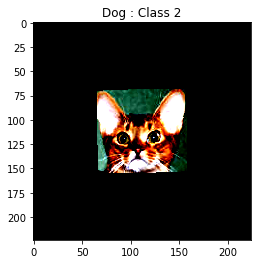

In [4]:
train_transform = transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.ColorJitter(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

train_data = CustomDataset(train_dir, mode='train', transform=train_transform)
test_data = CustomDataset(test_dir, mode='test', transform=test_transform)

torch.manual_seed(42)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

print(f'Training images available: {len(train_data)}')
print(f'Testing images available:  {len(test_data)}')

temp_image, temp_label = train_data[0]
if temp_label == "1":
    temp_label = "Cat : Class 1"
else:
    temp_label = "Dog : Class 2"

plt.imshow(temp_image.numpy().transpose((1, 2, 0)))

plt.title(temp_label)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


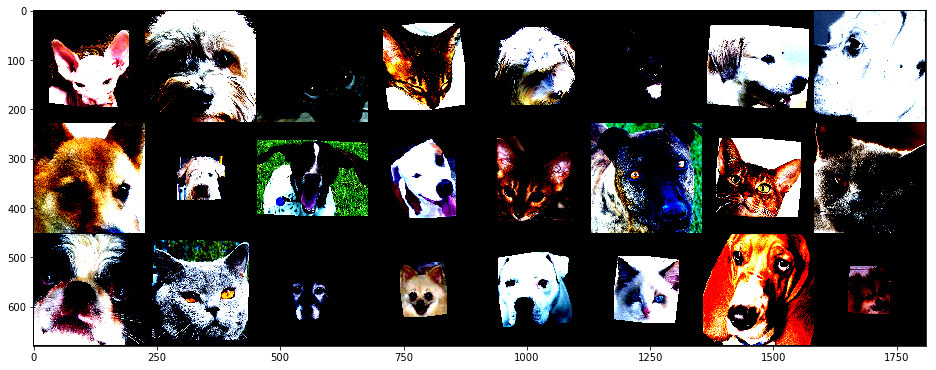

In [5]:
samples, labels = iter(train_loader).next()
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

In [6]:
device = 'cpu'
model = torchvision.models.densenet121(pretrained=True)

In [7]:
num_ftrs = model.classifier.in_features

model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 500),
    nn.Linear(500, 2)
)

model = model.to(device)
print(model)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, amsgrad=True)

    (norm): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    )
    (denseblock3): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(288, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(288, 128, kernel_size=(1, 1), stride=(1

In [10]:
import time
start_time = time.time()

epochs = 3

max_trn_batch = 10
max_tst_batch = 5

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    print("Started epoch {}".format(i))
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        print("batch {}".format(b))
        
        # Limit the number of batches
        if b == max_trn_batch:
            break
        b+=1
        
        # Apply the model
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        print("apply model")
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        print("updating parameters")
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print("updated parameters")

        # Print interim results
        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/8000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            # Limit the number of batches
            if b == max_tst_batch:
                break

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

Started epoch 0
batch 0
apply model
updating parameters
updated parameters
batch 1
apply model
updating parameters
updated parameters
batch 2
apply model
updating parameters
updated parameters
batch 3
apply model
updating parameters
updated parameters
batch 4
apply model
updating parameters
updated parameters
batch 5
apply model
updating parameters
updated parameters
batch 6
apply model
updating parameters
updated parameters
batch 7
apply model
updating parameters
updated parameters
batch 8
apply model
updating parameters
updated parameters
batch 9
apply model
updating parameters
updated parameters
batch 10
Started epoch 1
batch 0
apply model
updating parameters
updated parameters
batch 1
apply model
updating parameters
updated parameters
batch 2
apply model
updating parameters
updated parameters
batch 3
apply model
updating parameters
updated parameters
batch 4
apply model
updating parameters
updated parameters
batch 5
apply model
updating parameters
updated parameters
batch 6
apply m

In [11]:
filename_pth = 'ckpt_densenet121_catdog.pt'
torch.save(model.state_dict(), filename_pth)

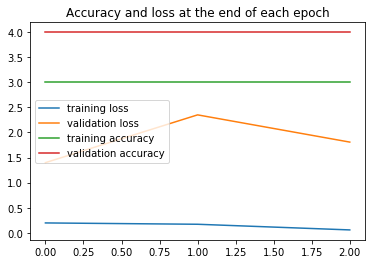

In [14]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')

plt.plot([t/80 for t in train_correct], label='training accuracy')
plt.plot([t/30 for t in test_correct], label='validation accuracy')
plt.title('Accuracy and loss at the end of each epoch')
plt.legend()

In [15]:
print(test_correct)
print(f'Test accuracy: {test_correct[-1].item()*100/3000:.3f}%')

[tensor(135), tensor(132), tensor(141)]
Test accuracy: 4.700%


Predicted value: 0 cat


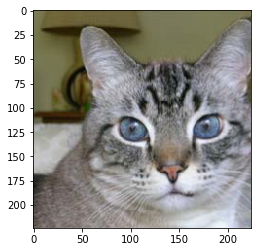

In [21]:
x = 14

inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im = inv_normalize(test_data[x][0])
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))

# CNN Model Prediction:
class_names = {0 : 'cat', 1 : 'dog'}

model.eval()
with torch.no_grad():
    new_pred = model(test_data[x][0].view(1,3,224,224)).argmax()
print(f'Predicted value: {new_pred.item()} {class_names[new_pred.item()]}')